In [0]:
#from google.colab import files
#uploaded = files.upload()

In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [0]:
import pickle
df = pickle.load( open( "incident_plus_weather.pkl", "rb" ) )

dftableau = pd.read_csv("test-for-tableau.csv")

In [19]:
df.head()


,Arrond,Month,DayOfWeek,TimeOfDay,Temp,RelHum,Pressure,WindSpd,TotalPrecip,CumulPrecip,SnowOnGrnd,WindPwr,Holiday,counts
0,0,1,0,0,0.001918,0.468750,0.784973,0.143617,0.000000,0.021382,0.170213,0.003239,0,3
1,0,1,0,0,0.053973,0.605469,0.751359,0.175532,0.000000,0.139803,0.382979,0.005827,1,5
2,0,1,0,0,0.076986,0.785156,0.997034,0.146277,0.000000,0.316612,0.553191,0.003407,0,2
3,0,1,0,0,0.090685,0.550781,0.765942,0.119681,0.000000,0.019737,0.340426,0.001832,0,3
4,0,1,0,0,0.108493,0.695313,0.501730,0.265957,0.014905,0.097862,0.361702,0.019673,0,4


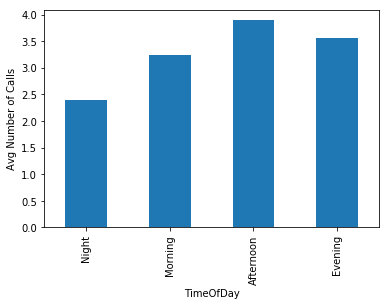

In [20]:
a = ['Night', 'Morning', 'Afternoon', 'Evening']

# Show the average number of calls by 6 hour time period
ax1 = df.groupby("TimeOfDay")['counts'].mean().plot(kind='bar')
ax1.set_ylabel("Avg Number of Calls")
ax1.set_xticklabels(a)
plt.savefig('avg_calls_per_period.png', bbox_inches='tight')

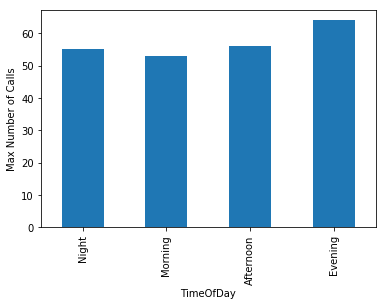

In [21]:
# Show the maximum number of calls by 6 hour time period
ax2 = df.groupby("TimeOfDay")['counts'].max().plot(kind='bar')
ax2.set_ylabel("Max Number of Calls")
ax2.set_xticklabels(a)
plt.savefig('max_calls_per_period.png', bbox_inches='tight')

In [0]:
# Determine whether there is an above average number of calls (more than 5) per time period. False =1, True =1.
# Based off observations taken during the data exploration phase
def call_bucket (row):
   if row['counts'] >=0 and row['counts']<=5 :
      return 0
   if row['counts'] > 5 :
      return 1
   return -1

# Creation new column for the hour bin/bucket and apply the previously created function to generate its values
df['Busy'] = df.apply (lambda row: call_bucket(row), axis=1)

In [0]:
# Keeping features : Temp, WindSpd, SnowOnGrnd, Holiday, Day of Week, Month, Time period, Borough
df.drop(["RelHum","Pressure","TotalPrecip","CumulPrecip","WindPwr"], axis=1, inplace=True)

In [0]:
# From the data set create a matrix of features (X), and predicted values (y). y = BusyDay (boolean)
X = df.drop(["counts","Busy"], axis=1).values
y = df["Busy"].values

In [0]:
from sklearn.model_selection import train_test_split

In [27]:
# Create training/test sets for X & y
#   Add stratify=y to ensure a better balance of 0 and 1's are included since it is a skewed data set (a lot more 0's)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(302755, 8) (302755,)
(129753, 8) (129753,)


In [0]:
import xgboost as xgb

In [0]:
# Objective - The objective funtions to use for classification.  In this case binary logistic since we are predicted 0 or 1
# Max depth -  Depth of each tree, which is the maximum number of different features used in each tree
# Subsample size - For each tree the % of rows taken to build the tree
# Colsample bytree - Number of columns used by each tree
# Gamma - Regularization parameter.
# Learning rate - A weighting (shrinkage) factor for the corrections by new trees when added to the model.
# scale_pos_weight - Control the balance of positive and negative weights, useful for unbalanced classes. Default 1
#    https://towardsdatascience.com/dealing-with-class-imbalanced-datasets-for-classification-2cc6fad99fd9

# Value ranges to consider for each paramte of an XGBoost algorigthm
#   https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
#   https://machinelearningmastery.com/tune-learning-rate-for-gradient-boosting-with-xgboost-in-python/
max_depth_vals = [1, 2, 3, 4, 5, 6, 7, 8]
subsample_vals = [0.7, 0.8, 0.9, 1]
colsample_bytree_vals = [0.7, 0.8, 0.9, 1]
gamma_vals = [0, 1, 5]
learning_rate_vals=[0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]

In [29]:
# Calculate scale_pos_weight using data set
unique_elements, counts_elements = np.unique(y_test, return_counts=True)

print("Values of y: " + str(unique_elements))
print("Counts per value: " + str(counts_elements))

# scale_pos_weight = positive values(1)/negative values(0)
spw = round(counts_elements[1]/counts_elements[0], 2)
print(spw)

Values of y: [0 1]
Counts per value: [106793  22960]
0.21


In [30]:
# Run through range of values for each tuning paramter to find the optimized values.  Keep number of estimateors at 100.
# Initial values to use to start tuning
# learning_rate: 0.01
# n_estimators: 100 
# max_depth: 3
# subsample: 0.8
# colsample_bytree: 1
# gamma: 1


# MAX DEPTH
# Create list to store parameter value, model score pairs
mdv_acc = []

# For each parameter value create model, fit, predict and score accuracy
for mdv in max_depth_vals:
  model_tuning = xgb.XGBClassifier(silent=True,
                      scale_pos_weight=spw,
                      learning_rate=0.01,
                      colsample_bytree = 1,
                      subsample = 0.8,
                      objective='binary:logistic',
                      n_estimators=100,
                      reg_alpha = 0.3,
                      max_depth=int(mdv),
                      gamma=1)
  model_tuning.fit(X_train, y_train)
  y_pred_tuning = model_tuning.predict(X_test)
  mdv_acc.append((mdv, model_tuning.score(X_test,y_test)))
  
# Store the paramter value which have the prediction the highest score
mdv_acc = np.array(mdv_acc)
mdv_optimal = int(mdv_acc[np.argmax(mdv_acc[:,1]),0])
print("Max Depth: "+str(mdv_optimal))


# SUBSAMPLE SIZE
# Create list to store parameter value, model score pairs
sss_acc = []

# For each parameter value create model, fit, predict and score accuracy
for sss in subsample_vals:
  model_tuning = xgb.XGBClassifier(silent=True, 
                      scale_pos_weight=spw,
                      learning_rate=0.01,  
                      colsample_bytree = 1,
                      subsample = sss,
                      objective='binary:logistic', 
                      n_estimators=100, 
                      reg_alpha = 0.3,
                      max_depth=mdv_optimal, 
                      gamma=1)
  model_tuning.fit(X_train, y_train)
  y_pred_tuning = model_tuning.predict(X_test)
  sss_acc.append((sss, model_tuning.score(X_test,y_test)))
  
# Store the paramter value which have the prediction the highest score
sss_acc = np.array(sss_acc)
sss_optimal = sss_acc[np.argmax(sss_acc[:,1]),0]
print("SubSample Size: "+str(sss_optimal))


# COLSAMPLE BYTREE
# Create list to store parameter value, model score pairs
col_acc = []

# For each parameter value create model, fit, predict and score accuracy
for col in colsample_bytree_vals:
  model_tuning = xgb.XGBClassifier(silent=True, 
                      scale_pos_weight=spw,
                      learning_rate=0.01,  
                      colsample_bytree = col,
                      subsample = sss_optimal,
                      objective='binary:logistic', 
                      n_estimators=100, 
                      reg_alpha = 0.3,
                      max_depth=mdv_optimal, 
                      gamma=1)
  model_tuning.fit(X_train, y_train)
  y_pred_tuning = model_tuning.predict(X_test)
  col_acc.append((col, model_tuning.score(X_test,y_test)))
  
# Store the paramter value which have the prediction the highest score
col_acc = np.array(col_acc)
col_optimal = col_acc[np.argmax(col_acc[:,1]),0]
print("Column Sample By Tree: "+str(col_optimal))


# GAMMA
# Create list to store parameter value, model score pairs
gam_acc = []

# For each parameter value create model, fit, predict and score accuracy
for gam in gamma_vals:
  model_tuning = xgb.XGBClassifier(silent=True, 
                      scale_pos_weight=spw,
                      learning_rate=0.01,  
                      colsample_bytree = col_optimal,
                      subsample = sss_optimal,
                      objective='binary:logistic', 
                      n_estimators=100, 
                      reg_alpha = 0.3,
                      max_depth=mdv_optimal, 
                      gamma=int(gam))
  model_tuning.fit(X_train, y_train)
  y_pred_tuning = model_tuning.predict(X_test)
  gam_acc.append((gam, model_tuning.score(X_test,y_test)))
  
# Store the paramter value which have the prediction the highest score
gam_acc = np.array(gam_acc)
gam_optimal = int(gam_acc[np.argmax(gam_acc[:,1]),0])
print("Gamma: "+str(gam_optimal))


# LEARNING RATE
# Create list to store parameter value, model score pairs
lrt_acc = []

# For each parameter value create model, fit, predict and score accuracy
for lrt in learning_rate_vals:
  model_tuning = xgb.XGBClassifier(silent=True, 
                      scale_pos_weight=spw,
                      learning_rate=lrt,  
                      colsample_bytree = col_optimal,
                      subsample = sss_optimal,
                      objective='binary:logistic', 
                      n_estimators=100, 
                      reg_alpha = 0.3,
                      max_depth=mdv_optimal, 
                      gamma=gam_optimal)
  model_tuning.fit(X_train, y_train)
  y_pred_tuning = model_tuning.predict(X_test)
  lrt_acc.append((lrt, model_tuning.score(X_test,y_test)))
  
# Store the paramter value which have the prediction the highest score
lrt_acc = np.array(lrt_acc)
lrt_optimal = lrt_acc[np.argmax(lrt_acc[:,1]),0]
print("Learning Rate: "+str(lrt_optimal))


NameError: ignored

In [31]:
# Max Depth: 3
# SubSample Size: 0.7
# Column Sample By Tree: 1.0
# Gamma: 0
# Learning Rate: 0.01
# Scale_pos_weight: 0.21

model = xgb.XGBClassifier(silent=False, 
                      scale_pos_weight=0.21,
                      learning_rate=0.01,  
                      colsample_bytree = 1.0,
                      subsample = 0.7,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=3, 
                      gamma=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(model.score(X_test,y_test))

0.8314412768876249


In [32]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred, labels=[0, 1])

array([[106667,    126],
       [ 21745,   1215]])

In [0]:
# Create dataframe of test set actual values and predicted values and dump to a pkl file
outputdata = pd.DataFrame({'Arrond':X_test[:,0],'Month':X_test[:,1], 'DayOfWeek':X_test[:,2],
                        'TimeOfDay':X_test[:,3], 'Temp':X_test[:,4], 'WindSpd':X_test[:,5],
                        'SnowOnGrnd':X_test[:,6],'Holiday':X_test[:,7]})
  
outputdata['Busy_real'] = y_test
outputdata['Busy_predicted'] = y_pred
  
outputdata.to_pickle('output_actual_predicted.pkl')

In [0]:
Xtableau = dftableau.values
ytableau_pred = model.predict(Xtableau)

In [0]:
outputdatatableau = pd.DataFrame({'Arrond':Xtableau[:,0],'Month':Xtableau[:,1], 'DayOfWeek':Xtableau[:,2],
                        'TimeOfDay':Xtableau[:,3], 'Temp':Xtableau[:,4], 'WindSpd':Xtableau[:,5],
                        'SnowOnGrnd':Xtableau[:,6],'Holiday':Xtableau[:,7]})
  
outputdatatableau['Busy_predicted'] = ytableau_pred
  
outputdatatableau.to_pickle('aug_tableau_predicted.pkl')
outputdatatableau.